In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [20]:
# Load CIFAR-10 dataset
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

In [33]:
# Normalize
num_classes = 10

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

In [34]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2)

In [35]:
# Augment
datagen = ImageDataGenerator(featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False,
                            rotation_range=15,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=True,
                            vertical_flip=False)

datagen.fit(X_train)

In [36]:
# learning_rates = [0.001, 0.0001]
# optimizers = ['adam', 'rms']
# batch_sizes = [32, 64]

learning_rates = [0.0001]
optimizers = ['adam']
batch_sizes = [64]
epochs = 10

# Function to create and train models with different hyperparameters
def create_and_train_model(optimizer='adam', learning_rate=0.001, batch_size=128):
    # Model
    model = keras.Sequential([
      Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4), input_shape=(32, 32, 3)),
      MaxPooling2D((2, 2)),
      Dropout(0.3),

      Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)),
      MaxPooling2D((2, 2)),
      Dropout(0.3),

      Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)),
      Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)),
      Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)),
      MaxPooling2D((2, 2)),
      Dropout(0.3),

      Flatten(),

      Dense(512, activation='relu'),
      Dropout(0.5),
      Dense(256, activation='relu'),
      Dropout(0.5),
      Dense(128, activation='relu'),
      Dropout(0.5),

      Dense(10, activation='softmax')
    ])

    # Compile
    model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size = batch_size),
                    steps_per_epoch = len(X_train) // batch_size,
                    epochs = epochs,
                    validation_data= (X_valid, Y_valid),
                    verbose=1)

    return model, history

# Tuning hyperparameters and saving the histories
models, histories = [], []
for lr in learning_rates:
    for opt in optimizers:
        for bs in batch_sizes:
            model, history = create_and_train_model(opt, learning_rate=lr, batch_size=bs)
            models.append(model)
            histories.append(history)

Epoch 1/10


<ipython-input-36-4c504b9013ab>:43: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size = batch_size),


625/625 [==============================] - 33s 48ms/step - loss: 2.3075 - accuracy: 0.0997 - val_loss: 2.3030 - val_accuracy: 0.0965
Epoch 2/10
625/625 [==============================] - 30s 48ms/step - loss: 2.3029 - accuracy: 0.1015 - val_loss: 2.3027 - val_accuracy: 0.1004
Epoch 3/10
625/625 [==============================] - 32s 50ms/step - loss: 2.3028 - accuracy: 0.0983 - val_loss: 2.3026 - val_accuracy: 0.1004
Epoch 4/10
625/625 [==============================] - 30s 47ms/step - loss: 2.3029 - accuracy: 0.0975 - val_loss: 2.3029 - val_accuracy: 0.0963
Epoch 5/10
625/625 [==============================] - 30s 47ms/step - loss: 2.3028 - accuracy: 0.0976 - val_loss: 2.3027 - val_accuracy: 0.0965
Epoch 6/10
625/625 [==============================] - 30s 48ms/step - loss: 2.3027 - accuracy: 0.1007 - val_loss: 2.3027 - val_accuracy: 0.1004
Epoch 7/10
625/625 [==============================] - 31s 50ms/step - loss: 2.3028 - accuracy: 0.0996 - val_loss: 2.3027 - val_accuracy: 0.1004
Epo

In [46]:
# Get the best model
# Extract validation accuracy values from each history object
val_acc_list = [h.history['val_accuracy'][-1] for h in histories]

# Find the index of the model with the highest validation accuracy
best_model_idx = np.argmax(val_acc_list)
best_model = models[best_model_idx]
best_history = histories[best_model_idx]

# Evaluate the best model on the test set
test_datagen = ImageDataGenerator()
test_datagen.fit(X_test)

loss, acc = best_model.evaluate(test_datagen.flow(X_test, Y_test, batch_size=32))
print('Test Loss: {}, Test Accuracy: {}'.format(loss, acc))

# Save the best model for future use
best_model_name = 'best_model.keras'
best_model.save(best_model_name)
print('Model: {} saved!'.format(best_model_name))


313/313 [==============================] - 3s 9ms/step - loss: 2.3026 - accuracy: 0.1000
Test Loss: 2.3026161193847656, Test Accuracy: 0.10000000149011612
Model: best_model.keras saved!


In [38]:
# Load the best model
from keras.models import load_model
loaded_model = load_model(best_model_name)

# Get predictions on the test set
y_pred = loaded_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

313/313 [==============================] - 2s 5ms/step


In [39]:
# Function for Confusion Matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize confusion matrix values to display percentages
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    for i, j in np.ndenumerate(cm):
      row, col = i
      value = f"{cm[row, col]:.2f}"
      plt.text(col, row, value, ha='center', va='center', fontsize=8, fontweight='bold', color='black')

    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Function for Loss & Accuracy (subplot)
def plot_loss_accuracy_using_subplot():
  plt.figure(figsize=(12, 6))

  plt.subplot(1, 2, 1)
  plt.plot(best_history.history['loss'], label='Training Loss')
  plt.plot(best_history.history['val_loss'], label='Validation Loss')
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(best_history.history['accuracy'], label='Training Accuracy')
  plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [27]:
# Classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Confusion Matrix
cm = confusion_matrix(Y_test, y_pred)

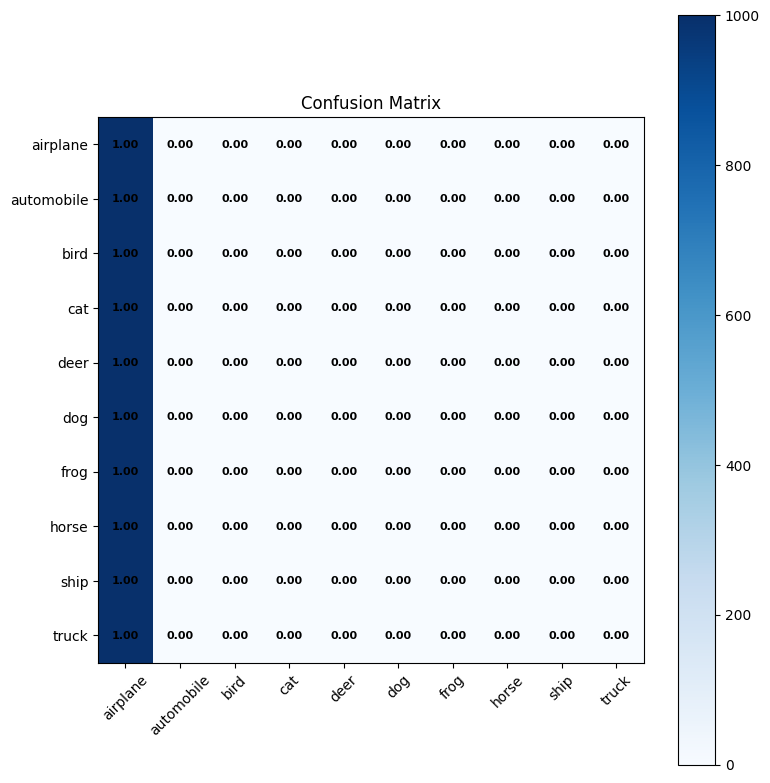

In [28]:
# Plot Confusion Matrix
plot_confusion_matrix(cm, class_names)  # Visualize confusion matrix

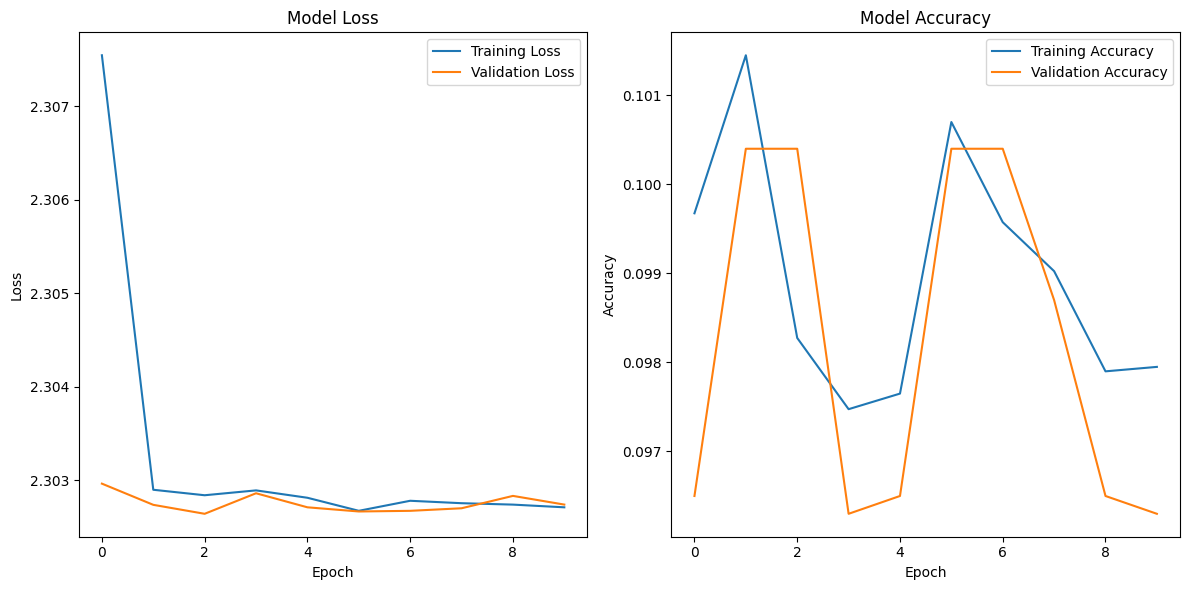

In [40]:
# Plot Loss & Accuracy using subplot
plot_loss_accuracy_using_subplot()

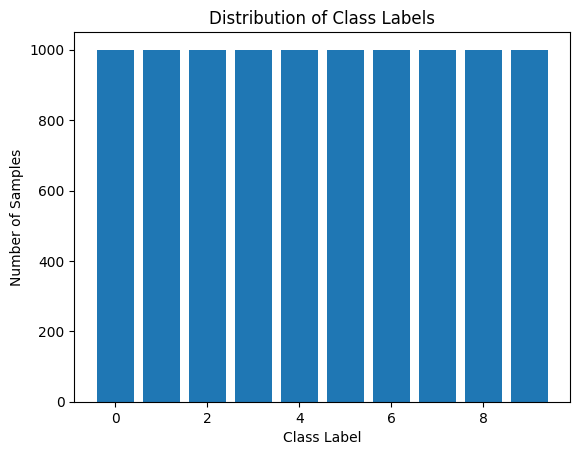

In [47]:
# Distribution of class_labels
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
class_labels, counts = np.unique(Y_test, return_counts=True)

plt.bar(class_labels, counts)
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Distribution of Class Labels')
plt.show()

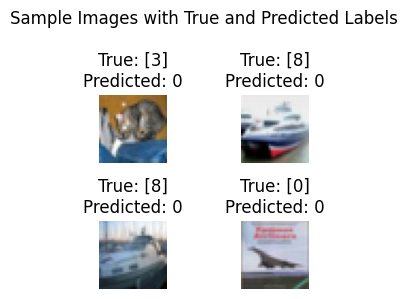

In [49]:
# Assuming you have sample images (X_test), true labels (Y_test), and predicted labels (y_pred)
num_images = 4  # Adjust the number of images

fig, axes = plt.subplots(2, 2, figsize=(3, 3))

for i in range(num_images):
    image = X_test[i]
    true_label = class_labels[Y_test[i]]
    predicted_label = class_labels[y_pred[i]]

    axes[i // 2, i % 2].imshow(image)
    axes[i // 2, i % 2].set_title(f"True: {true_label}\nPredicted: {predicted_label}")
    axes[i // 2, i % 2].axis('off')

fig.suptitle(f"Sample Images with True and Predicted Labels")
plt.tight_layout()
plt.show()

Epoch 1/3
938/938 [==============================] - 5s 4ms/step - loss: 0.2749 - accuracy: 0.9176 - val_loss: 0.0773 - val_accuracy: 0.9761 - lr: 0.0010
Epoch 2/3
938/938 [==============================] - 4s 5ms/step - loss: 0.1141 - accuracy: 0.9662 - val_loss: 0.0544 - val_accuracy: 0.9817 - lr: 0.0010
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 0.0478 - accuracy: 0.9828
Test Loss: 0.047753963619470596 Test Accuracy: 0.9828000068664551


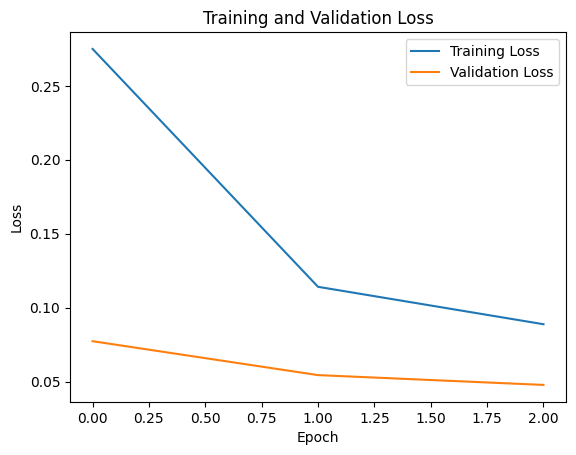

In [50]:
## On MNIST data

from tensorflow import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt  # Import for plotting

# Load MNIST data
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Reshape to add channel dimension
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Normalize pixel values
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Define learning rate, batch size, and epochs
learning_rate = 0.001
batch_size = 64
epochs = 3

# Build the model
model = keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # 10 units for 10 classes
])

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate),
              loss='sparse_categorical_crossentropy',  # Categorical crossentropy for MNIST
              metrics=['accuracy'])

# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)

# Train the model (without ImageDataGenerator)
history = model.fit(X_train, Y_train,
                    epochs=epochs,
                    validation_data=(X_test, Y_test),
                    batch_size=batch_size,
                    verbose=1,
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, Y_test, batch_size=32)
print('Test Loss:', loss, 'Test Accuracy:', accuracy)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

313/313 [==============================] - 1s 2ms/step
Confusion matrix without normalization


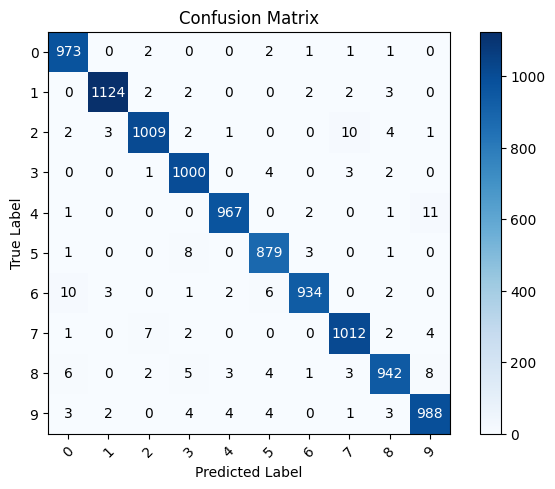

In [51]:
# Predict on test data
import numpy as np
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# Function to plot the confusion matrix (optional)
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix without normalization")
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Plot confusion matrix (optional)
plot_confusion_matrix(cm, classes=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

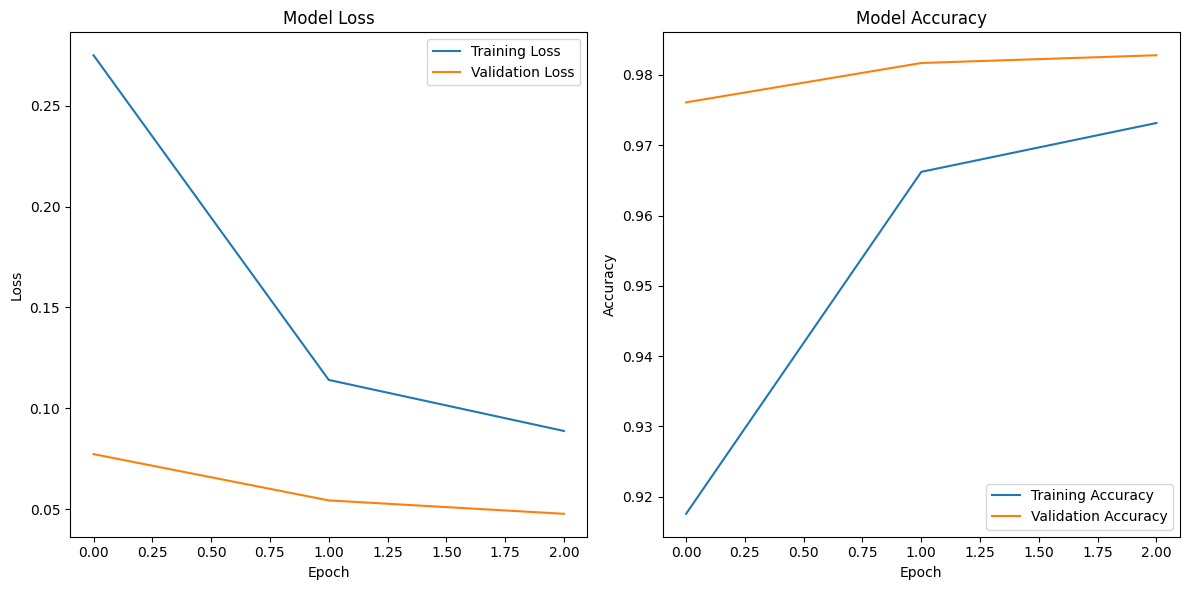

In [52]:
# Plot training and testing loss/accuracy (using subplots)
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(121)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

# Accuracy plot
plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

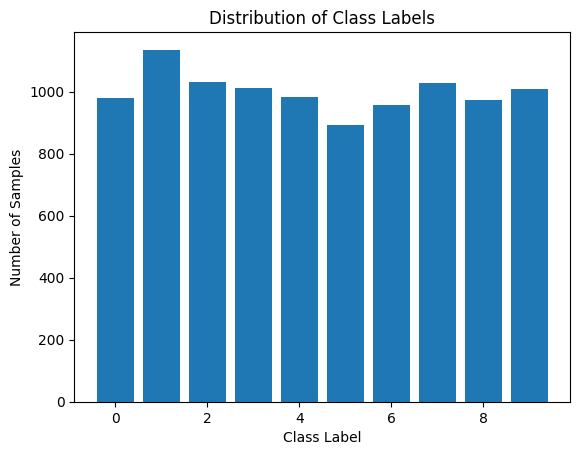

In [53]:
# Distribution of class_labels
class_labels, counts = np.unique(Y_test, return_counts=True)

plt.bar(class_labels, counts)
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Distribution of Class Labels')
plt.show()

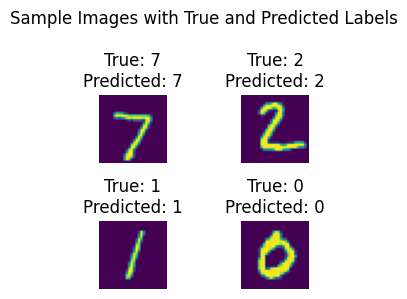

In [54]:
# Assuming you have sample images (X_test), true labels (Y_test), and predicted labels (y_pred)
num_images = 4  # Adjust the number of images

fig, axes = plt.subplots(2, 2, figsize=(3, 3))

for i in range(num_images):
    image = X_test[i]
    true_label = class_labels[Y_test[i]]
    predicted_label = class_labels[y_pred[i]]

    axes[i // 2, i % 2].imshow(image)
    axes[i // 2, i % 2].set_title(f"True: {true_label}\nPredicted: {predicted_label}")
    axes[i // 2, i % 2].axis('off')

fig.suptitle(f"Sample Images with True and Predicted Labels")
plt.tight_layout()
plt.show()